In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

In [27]:
# Example Dataset
data_start = pd.DataFrame({
    'Month': pd.date_range(start='2020-01-01', periods=36, freq='ME'),
    'Sales': np.random.randint(200, 500, 36)
})
data = data_start.copy()
# Create Features (e.g., Lagged Sales and Time Index)
data['MonthIndex'] = np.arange(len(data))  # Numeric time index
data['Lag1'] = data['Sales'].shift(1)     # Lag feature
data['Lag2'] = data['Sales'].shift(2)

# Drop rows with NaN due to lagging
data = data.dropna()

# Add 'Month' column to features
X = data[['MonthIndex', 'Lag1', 'Lag2']]
y = data['Sales']

# Keep track of the corresponding months
data['Month'] = data['Month']

# Split into train and test
X_train, X_test, y_train, y_test, months_train, months_test = train_test_split(
    X, y, data['Month'], test_size=0.2, random_state=42
)

       Month  Actual Sales  Predicted (LinearRegression)  Predicted (XGBoost)
0 2020-11-30           224                    388.795497           326.867859
1 2021-06-30           329                    398.840009           345.929352
2 2021-10-31           246                    358.320013           359.463715
3 2021-12-31           349                    347.713116           330.251587
4 2022-03-31           368                    393.050820           367.830017
5 2022-05-31           255                    375.048813           390.351715
6 2022-06-30           413                    416.550394           377.725525

XGBoost:
R2 Score: -0.438779354095459
RMSE: 78.97406548386799
Linear Regression:
R2 Score: -0.9675880078631254
RMSE: 92.35373804067449


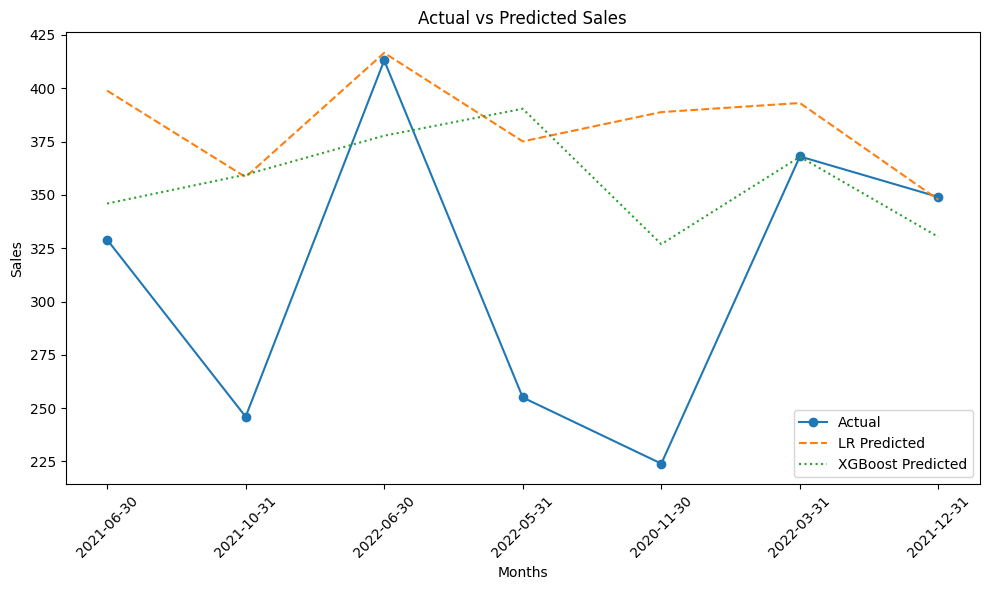

In [31]:
# Train the Linear Regression model
lr_model.fit(X_train, y_train)

# Predict with Linear Regression
y_pred = lr_model.predict(X_test)

# Prepare XGBoost datasets
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Train the XGBoost model
params = {'objective': 'reg:squarederror', 'max_depth': 3, 'learning_rate': 0.1}
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Predict with XGBoost
y_pred_xgb = xgb_model.predict(dtest)

# Combine results into a DataFrame with real months
results = pd.DataFrame({
    'Month': months_test.values,  # Use real months from the test set
    'Actual Sales': y_test.values,
    'Predicted (LinearRegression)': y_pred,
    'Predicted (XGBoost)': y_pred_xgb
}).sort_values(by='Month')

# Reset the index to align with Month
results = results.reset_index(drop=True)

# Display the table
print(results)
print("\nXGBoost:")
print("R2 Score:", r2_score(y_test, y_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("Linear Regression:")
print("R2 Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

formatted_months = pd.to_datetime(months_test.values).strftime('%Y-%m-%d')

# Update the plot with formatted x-axis labels
plt.figure(figsize=(10, 6))

# Plot the actual and predicted values
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='LR Predicted', linestyle='dashed')
plt.plot(y_pred_xgb, label='XGBoost Predicted', linestyle='dotted')

# Add the x-axis labels with formatted dates
plt.xticks(
    ticks=range(len(months_test)),  # Positions for the ticks
    labels=formatted_months,  # Formatted date labels
    rotation=45  # Rotate for readability
)

# Add title, legend, and axis labels
plt.title('Actual vs Predicted Sales')
plt.xlabel('Months')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()  # Ensure everything fits nicely
plt.show()

In [21]:
# Generate future months
last_month = data['Month'].max()
future_months = pd.date_range(start=last_month, periods=12, freq='ME')  # Forecast for 12 future months

# Prepare future features using the most recent data
future_data = pd.DataFrame({
    'Month': future_months,
    'MonthIndex': np.arange(len(data), len(data) + len(future_months)),
    'Lag1': data['Sales'].iloc[-1],  # Last known sales value
    'Lag2': data['Sales'].iloc[-2]   # Second-to-last known sales value
})

# Predict future sales
future_features = future_data[['MonthIndex', 'Lag1', 'Lag2']]
future_data['Predicted (LinearRegression)'] = lr_model.predict(future_features)
future_data['Predicted (XGBoost)'] = xgb_model.predict(xgb.DMatrix(future_features))

# Combine past and future into one table
all_results = pd.concat([data_start, future_data[['Month', 'Predicted (LinearRegression)', 'Predicted (XGBoost)']]])
all_results = pd.concat([all_results, results[['Month', 'Predicted (LinearRegression)', 'Predicted (XGBoost)']]])

all_results

,Month,Sales,Predicted (LinearRegression),Predicted (XGBoost)
0,2020-01-31,250.0,NaN,NaN
1,2020-02-29,422.0,NaN,NaN
2,2020-03-31,241.0,NaN,NaN
3,2020-04-30,350.0,NaN,NaN
4,2020-05-31,428.0,NaN,NaN
5,2020-06-30,322.0,NaN,NaN
6,2020-07-31,331.0,NaN,NaN
7,2020-08-31,284.0,NaN,NaN
8,2020-09-30,246.0,NaN,NaN
9,2020-10-31,312.0,NaN,NaN


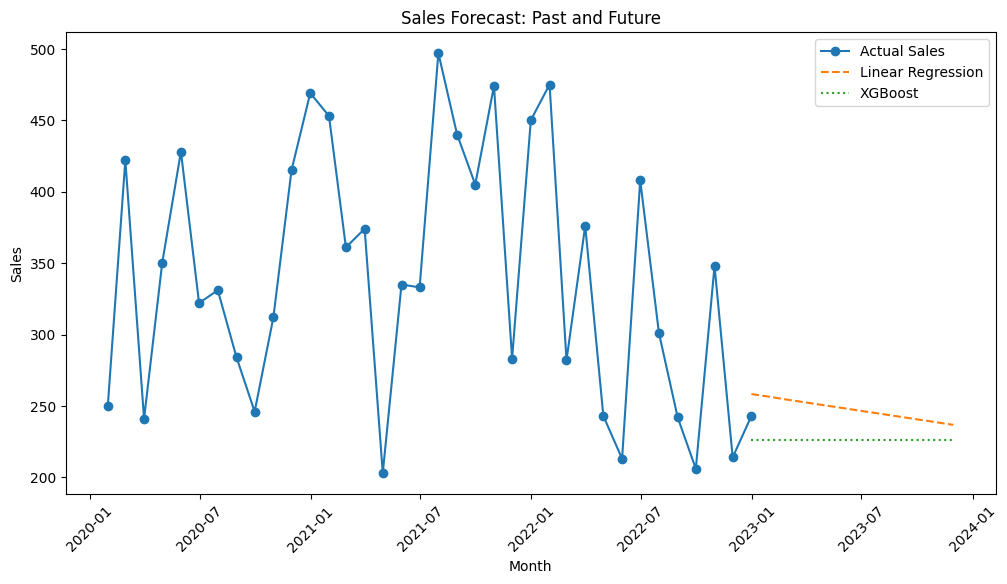

In [24]:
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(data_start['Month'], data_start['Sales'], label='Actual Sales', marker='o')

# Plot predictions
plt.plot(all_results['Month'], all_results['Predicted (LinearRegression)'], label='Linear Regression', linestyle='--')
plt.plot(all_results['Month'], all_results['Predicted (XGBoost)'], label='XGBoost', linestyle='dotted')


plt.legend()
plt.title('Sales Forecast: Past and Future')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()